In [12]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

%matplotlib inline


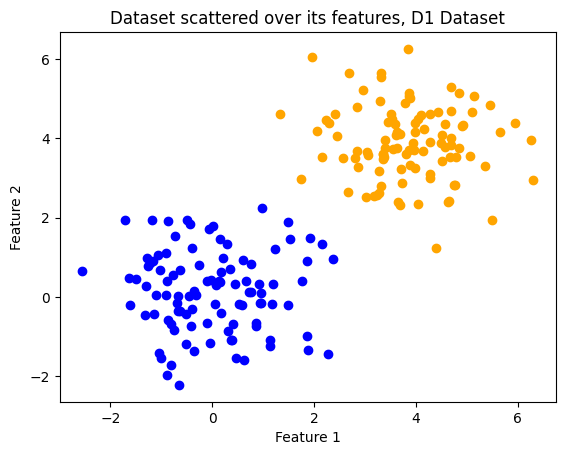

In [13]:
first100 = np.random.normal(0, 1, (100, 2))
second100 = np.random.normal(3, 1, (100, 2)) + 1

plt.scatter(first100[:, 0], first100[:, 1], color="blue")
plt.scatter(second100[:, 0], second100[:, 1], color="orange")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Dataset scattered over its features, D1 Dataset")
plt.show()



The dataset above is the D1 dataset. It is linealy separable. We will test Hard Margin SVM and Soft Margin SVM on this dataset.

In [14]:
np.random.shuffle(first100)  # Introduce randomization to train-test set selections
np.random.shuffle(second100)
train_dataset = np.concatenate((first100[:90], second100[:90]), axis=0)
test_dataset = np.concatenate((first100[90:], second100[90:]), axis=0)

dataset = np.concatenate((first100, second100), axis=0)
labels = np.concatenate((np.ones((100,), dtype=np.int8), -np.ones((100,), dtype=np.int8)))
train_labels = np.concatenate((np.ones((90,), dtype=np.int8), -np.ones((90,), dtype=np.int8)))
test_labels = np.concatenate((np.ones((10,), dtype=np.int8), -np.ones((10,), dtype=np.int8)))
print(dataset.shape)

(200, 2)


Data preparation and separation to train and test samples. Before picking the training and testing dataset, each group is shuffled internally. This way, randomization is introduced into the system (If we omit data generations randomness as a factor). 

In [15]:


def evaluate(W, b, data, labels) -> np.float32:
    """
        Evaluates the accuracy of the SVM. 
    """
    correct = 0
    for i, x in enumerate(data):
        y_pred = x.T @ W + b
        if y_pred > 0 and labels[i] == 1:
            correct += 1
        elif y_pred < 0 and labels[i] == -1:
            correct += 1
    return correct / data.shape[0]
    
    

def loss_hard_margin(W, b, data: np.ndarray, labels: np.ndarray) -> np.float32:
    """
        Calculates the loss for the hard margin SVM. We use the exponential
        softmax loss function.
    """
    error = 0
    for i, x in enumerate(data):
        error += np.log(1 + np.exp(- labels[i] * (b - x.T @ W)))
    return error[0] / data.shape[0]

def loss_soft_margin(W, b, data: np.ndarray, labels: np.ndarray, l: np.float32 = 0.01) -> np.float32:
    """
        Calculates the loss for the soft margin SVM. We use the exponential
        softmax loss function. Regularization term is added to the error at 
        the end of all calculations. This way, we don't add the same term
        over and over again at each iteration.
    """
    error = 0
    for i, x in enumerate(data):
        error += np.log(1 + np.exp(- labels[i] * (b - x.T @ W)))
    return (error[0] + l * np.linalg.norm(W)) / data.shape[0]

def hard_margin(train_data: np.ndarray, test_data: np.ndarray, train_labels: np.ndarray, test_labels: np.ndarray, 
                lr: np.float32 = 0.01, epochs: int = 5):
    """
        Trains a hard margin SVM, given the parameters. Default learning rate is 0.01.
        Default epoch number is 5. Returns the calculated W and b.
    """
    W = (np.random.rand(2) - 0.5) * 3
    b = (np.random.rand(1) - 0.5) * 3
    
    for epoch in range(epochs):
        for i, x in enumerate(train_data):
            y_pred = (x.T @ W + b)
            if (y_pred > 0 and train_labels[i] == 1) or (y_pred < 0 and train_labels[i] == -1):
                continue
            W = W + lr * train_labels[i] * x
            b = b + lr * train_labels[i]
        print(f"Loss at epoch {epoch + 1} is {loss_hard_margin(W, b, test_data, test_labels):.5f}")
    
    return W, b

def soft_margin(train_data: np.ndarray, test_data: np.ndarray, train_labels: np.ndarray, test_labels: np.ndarray, 
                lr: np.float32 = 0.01, l: np.float32 = 0.01, epochs: int = 5):
    """
        Trains a soft margin SVM, given the parameters. Default learning rate is 0.01.
        Default epoch number is 5. Default lambda is 0.01. Returns the calculated W and b.
    """
    W = (np.random.rand(2) - 0.5) * 3
    b = (np.random.rand(1) - 0.5) * 3
    
    for epoch in range(epochs):
        for i, x in enumerate(train_data):
            y_pred = (x.T @ W + b)
            if (y_pred > 0 and train_labels[i] == 1) or (y_pred < 0 and train_labels[i] == -1):
                W = W - 2 * l * lr * W
                continue
            W = W + lr * train_labels[i] * x - 2 * l * lr * W
            b = b + lr * train_labels[i]
        print(f"Loss at epoch {epoch + 1} is {loss_hard_margin(W, b, test_data, test_labels):.5f}")
    
    return W, b
        
    


Parameters here are fine tuned via experimentation to result in best accuracies and modeling.

In [16]:
W_hard, b_hard = hard_margin(train_dataset, test_dataset, train_labels, test_labels, lr=0.03, epochs=5)
print(f"Accuracy of the hard margin SVM is {evaluate(W_hard, b_hard, dataset, labels):.5f}")

W_soft, b_soft = soft_margin(train_dataset, test_dataset, train_labels, test_labels, lr=0.03, l=0.2, epochs=5)
print(f"Accuracy of the soft margin SVM is {evaluate(W_soft, b_soft, dataset, labels):.5f}")

Loss at epoch 1 is 1.42236
Loss at epoch 2 is 1.17265
Loss at epoch 3 is 1.18703
Loss at epoch 4 is 1.18679
Loss at epoch 5 is 1.04688
Accuracy of the hard margin SVM is 1.00000
Loss at epoch 1 is 1.03441
Loss at epoch 2 is 1.02089
Loss at epoch 3 is 0.82053
Loss at epoch 4 is 0.81228
Loss at epoch 5 is 0.80875
Accuracy of the soft margin SVM is 1.00000


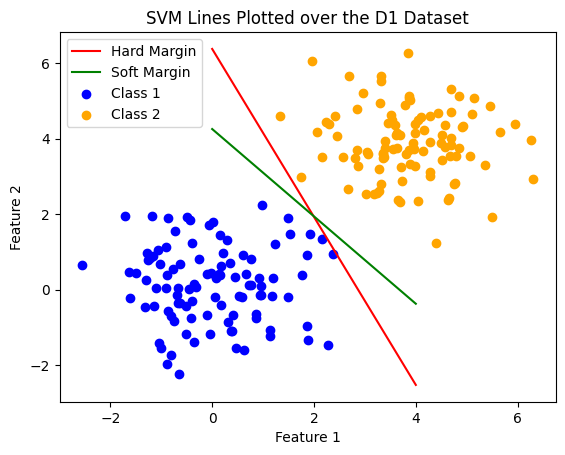

In [17]:
hard = lambda x: (-b_hard - W_hard[0]*x) / W_hard[1]
soft = lambda x: (-b_soft - W_soft[0]*x) / W_soft[1]

plt.plot(np.arange(0, 5), [hard(x) for x in np.arange(0, 5)], color="red", label="Hard Margin")
plt.plot(np.arange(0, 5), [soft(x) for x in np.arange(0, 5)], color="green", label="Soft Margin")
plt.scatter(first100[:, 0], first100[:, 1], color="blue", label="Class 1")
plt.scatter(second100[:, 0], second100[:, 1], color="orange", label="Class 2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM Lines Plotted over the D1 Dataset")
plt.legend()
plt.show()

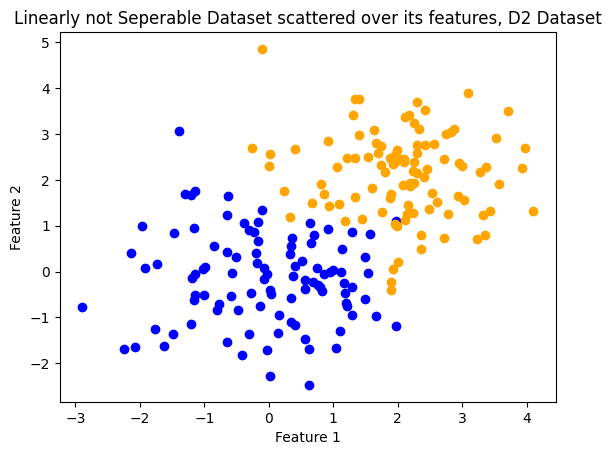

In [18]:
first100_nonlinear = np.random.normal(0, 1, (100, 2))
second100_nonlinear = np.random.normal(2.2, 1, (100, 2))

plt.scatter(first100_nonlinear[:, 0], first100_nonlinear[:, 1], color="blue")
plt.scatter(second100_nonlinear[:, 0], second100_nonlinear[:, 1], color="orange")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Linearly not Seperable Dataset scattered over its features, D2 Dataset")
plt.show()

In [19]:
np.random.shuffle(first100_nonlinear)  # Introduce randomization to train-test set selections
np.random.shuffle(second100_nonlinear)

# We just redefine the parameters used in D1 section.
train_dataset = np.concatenate((first100_nonlinear[:90], second100_nonlinear[:90]), axis=0)
test_dataset = np.concatenate((first100_nonlinear[90:], second100_nonlinear[90:]), axis=0)

dataset = np.concatenate((first100_nonlinear, second100_nonlinear), axis=0)
labels = np.concatenate((np.ones((100,), dtype=np.int8), -np.ones((100,), dtype=np.int8)))
train_labels = np.concatenate((np.ones((90,), dtype=np.int8), -np.ones((90,), dtype=np.int8)))
test_labels = np.concatenate((np.ones((10,), dtype=np.int8), -np.ones((10,), dtype=np.int8)))
print(dataset.shape)

(200, 2)


Training the models for the linearly not separable dataset.

In [20]:
W_hard, b_hard = hard_margin(train_dataset, test_dataset, train_labels, test_labels, lr=0.03, epochs=5)
print(f"Accuracy of the hard margin SVM is {evaluate(W_hard, b_hard, dataset, labels):.5f}")

W_soft, b_soft = soft_margin(train_dataset, test_dataset, train_labels, test_labels, lr=0.03, l=0.2, epochs=5)
print(f"Accuracy of the soft margin SVM is {evaluate(W_soft, b_soft, dataset, labels):.5f}")

Loss at epoch 1 is 1.85301
Loss at epoch 2 is 1.78813
Loss at epoch 3 is 1.79569
Loss at epoch 4 is 1.75606
Loss at epoch 5 is 1.76374
Accuracy of the hard margin SVM is 0.96500
Loss at epoch 1 is 0.75710
Loss at epoch 2 is 0.77497
Loss at epoch 3 is 0.71903
Loss at epoch 4 is 0.74897
Loss at epoch 5 is 0.72139
Accuracy of the soft margin SVM is 0.95500


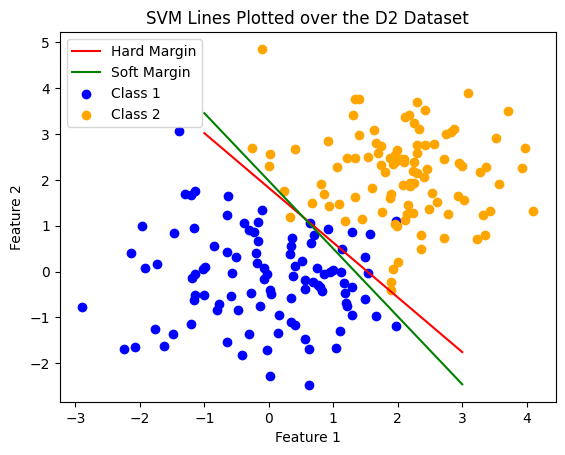

In [21]:
hard = lambda x: (-b_hard - W_hard[0]*x) / W_hard[1]
soft = lambda x: (-b_soft - W_soft[0]*x) / W_soft[1]

plt.plot(np.arange(-1, 4), [hard(x) for x in np.arange(-1, 4)], color="red", label="Hard Margin")
plt.plot(np.arange(-1, 4), [soft(x) for x in np.arange(-1, 4)], color="green", label="Soft Margin")
plt.scatter(first100_nonlinear[:, 0], first100_nonlinear[:, 1], color="blue", label="Class 1")
plt.scatter(second100_nonlinear[:, 0], second100_nonlinear[:, 1], color="orange", label="Class 2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM Lines Plotted over the D2 Dataset")
plt.legend()
plt.show()

In [22]:
print(f"Test accuracy of Hard Margin SVM on Linearly Inseparable Data: {evaluate(W_hard, b_hard, test_dataset, test_labels)}")
print(f"Test accuracy of Soft Margin SVM on Linearly Inseparable Data: {evaluate(W_soft, b_soft, test_dataset, test_labels)}")

Test accuracy of Hard Margin SVM on Linearly Inseparable Data: 0.95
Test accuracy of Soft Margin SVM on Linearly Inseparable Data: 0.9
